In [167]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style
import seaborn as sns

from datetime import datetime
import scipy.stats as stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

import os 
import warnings
warnings.filterwarnings('ignore')

In [168]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [169]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [170]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [171]:
train.get_dtype_counts()

float64     3
int64      35
object     43
dtype: int64

In [172]:
missing = train.isnull().sum().sort_values(ascending=False)
missing

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

In [173]:
missing / len(train)

PoolQC           0.995205
MiscFeature      0.963014
Alley            0.937671
Fence            0.807534
FireplaceQu      0.472603
LotFrontage      0.177397
GarageCond       0.055479
GarageType       0.055479
GarageYrBlt      0.055479
GarageFinish     0.055479
GarageQual       0.055479
BsmtExposure     0.026027
BsmtFinType2     0.026027
BsmtFinType1     0.025342
BsmtCond         0.025342
BsmtQual         0.025342
MasVnrArea       0.005479
MasVnrType       0.005479
Electrical       0.000685
Utilities        0.000000
YearRemodAdd     0.000000
MSSubClass       0.000000
Foundation       0.000000
ExterCond        0.000000
ExterQual        0.000000
Exterior2nd      0.000000
Exterior1st      0.000000
RoofMatl         0.000000
RoofStyle        0.000000
YearBuilt        0.000000
                   ...   
GarageArea       0.000000
PavedDrive       0.000000
WoodDeckSF       0.000000
OpenPorchSF      0.000000
3SsnPorch        0.000000
BsmtUnfSF        0.000000
ScreenPorch      0.000000
PoolArea    

In [174]:
def missing_percentage(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    missing = missing[missing!=0]
    per = round(missing / len(df), 3)[missing!=0]
    types = df[missing.index].dtypes[missing!=0]
#     print(per)
    return pd.concat([missing, per, types], axis=1, keys=['Total', 'Percent', 'Types'])

missing_percentage(train)

,Total,Percent,Types
PoolQC,1453,0.995,object
MiscFeature,1406,0.963,object
Alley,1369,0.938,object
Fence,1179,0.808,object
FireplaceQu,690,0.473,object
LotFrontage,259,0.177,float64
GarageCond,81,0.055,object
GarageType,81,0.055,object
GarageYrBlt,81,0.055,float64
GarageFinish,81,0.055,object


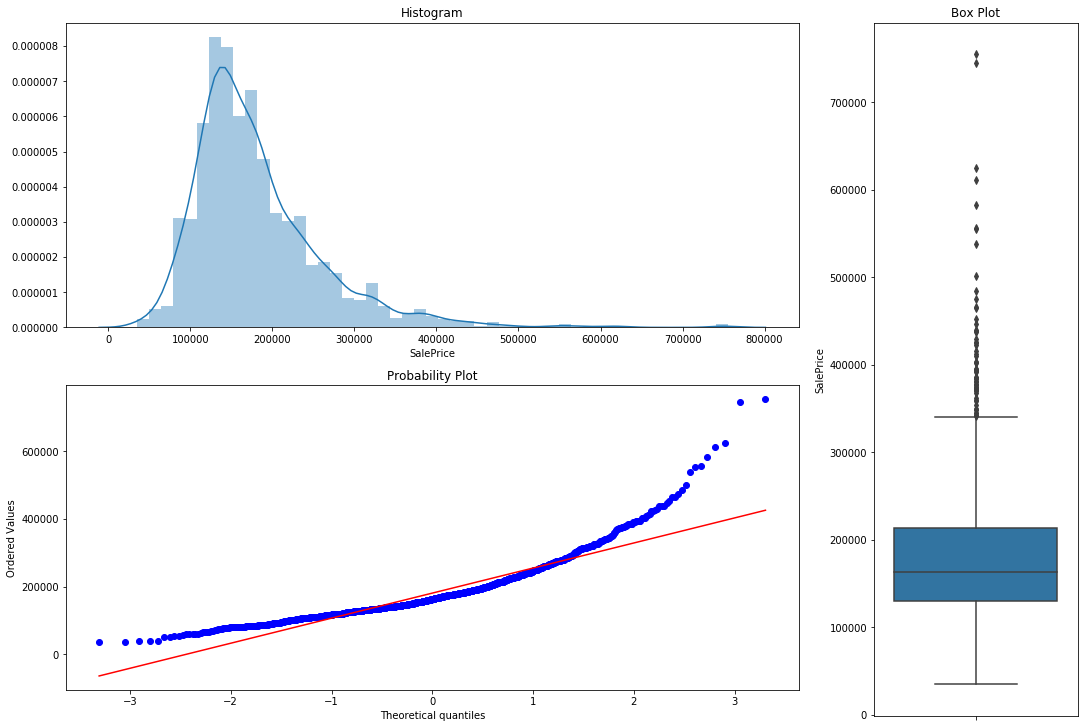

In [175]:
def plotting_3_chart(df, feature):
    fig = plt.figure(constrained_layout=True, figsize=(15, 10))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature], norm_hist=True, ax=ax1)
    
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plor')
    stats.probplot(df.loc[:, feature], plot=ax2)
    
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:, feature], orient='v', ax=ax3)

plotting_3_chart(train, 'SalePrice')

In [176]:
print('Skewness:', str(train['SalePrice'].skew()))
print('Kurtosis:', str(train['SalePrice'].kurt()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [177]:
(train.corr()**2)['SalePrice'].sort_values(ascending=False)[1:]

OverallQual      0.625652
GrLivArea        0.502149
GarageCars       0.410124
GarageArea       0.388667
TotalBsmtSF      0.376481
1stFlrSF         0.367057
FullBath         0.314344
TotRmsAbvGrd     0.284860
YearBuilt        0.273422
YearRemodAdd     0.257151
GarageYrBlt      0.236548
MasVnrArea       0.228000
Fireplaces       0.218023
BsmtFinSF1       0.149320
LotFrontage      0.123763
WoodDeckSF       0.105244
2ndFlrSF         0.101974
OpenPorchSF      0.099765
HalfBath         0.080717
LotArea          0.069613
BsmtFullBath     0.051585
BsmtUnfSF        0.046001
BedroomAbvGr     0.028296
KitchenAbvGr     0.018471
EnclosedPorch    0.016532
ScreenPorch      0.012420
PoolArea         0.008538
MSSubClass       0.007104
OverallCond      0.006062
MoSold           0.002156
3SsnPorch        0.001988
YrSold           0.000837
LowQualFinSF     0.000656
Id               0.000480
MiscVal          0.000449
BsmtHalfBath     0.000284
BsmtFinSF2       0.000129
Name: SalePrice, dtype: float64

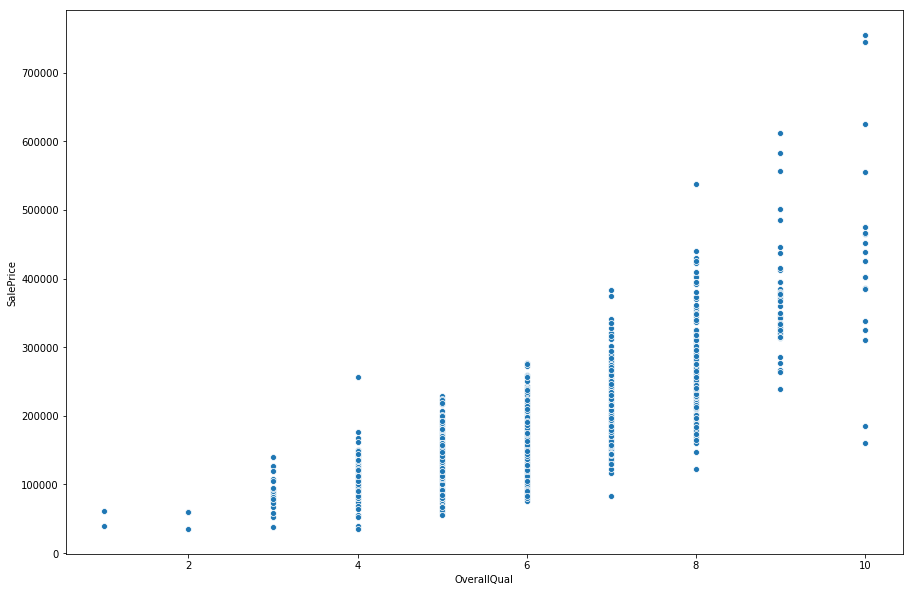

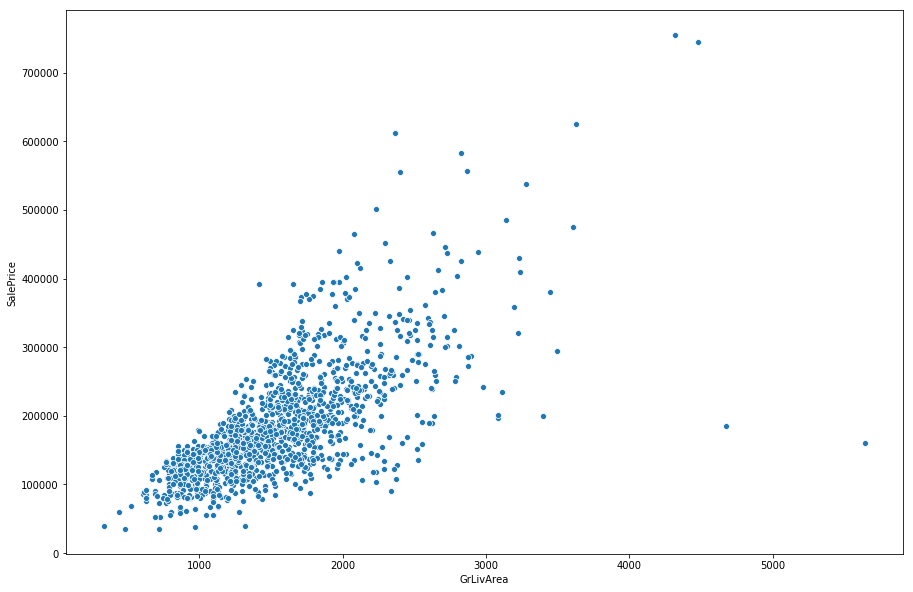

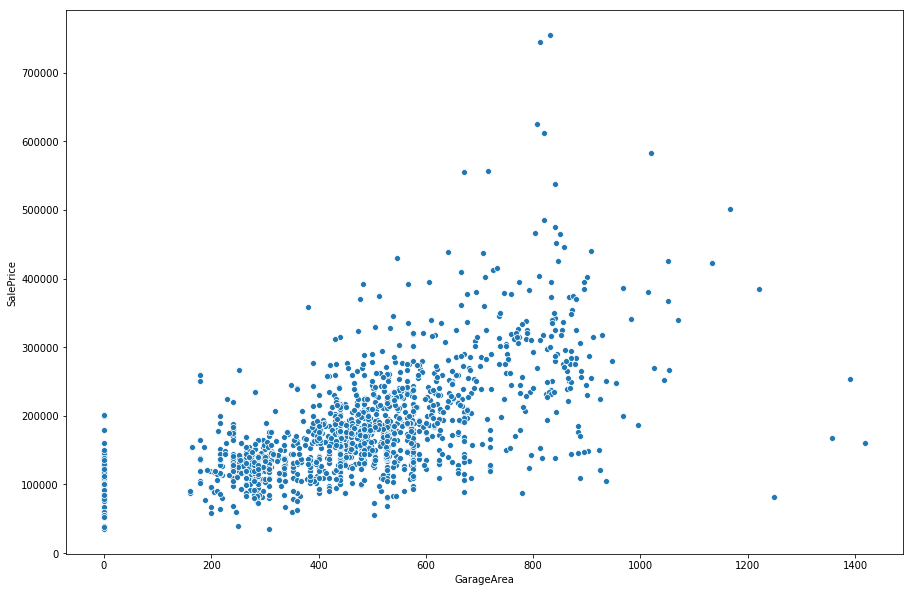

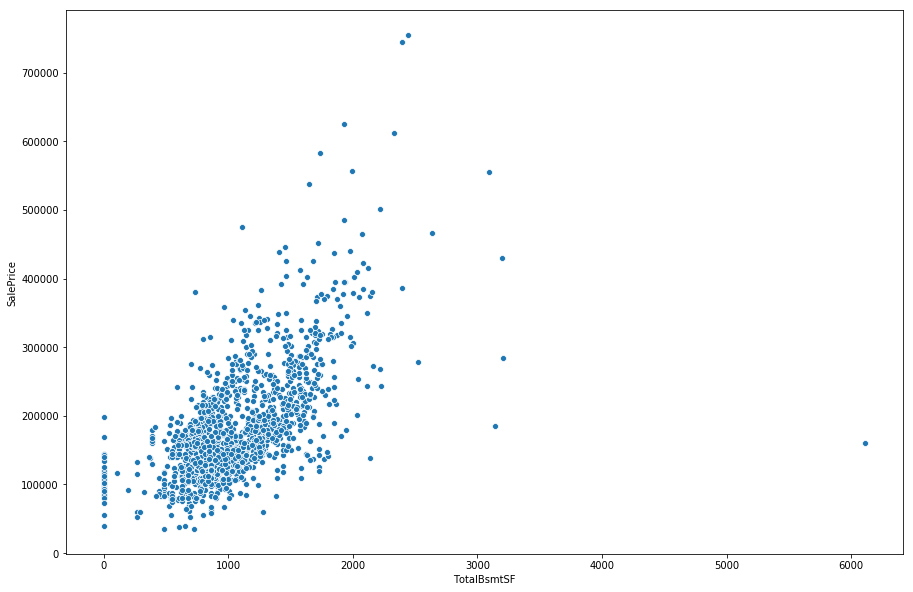

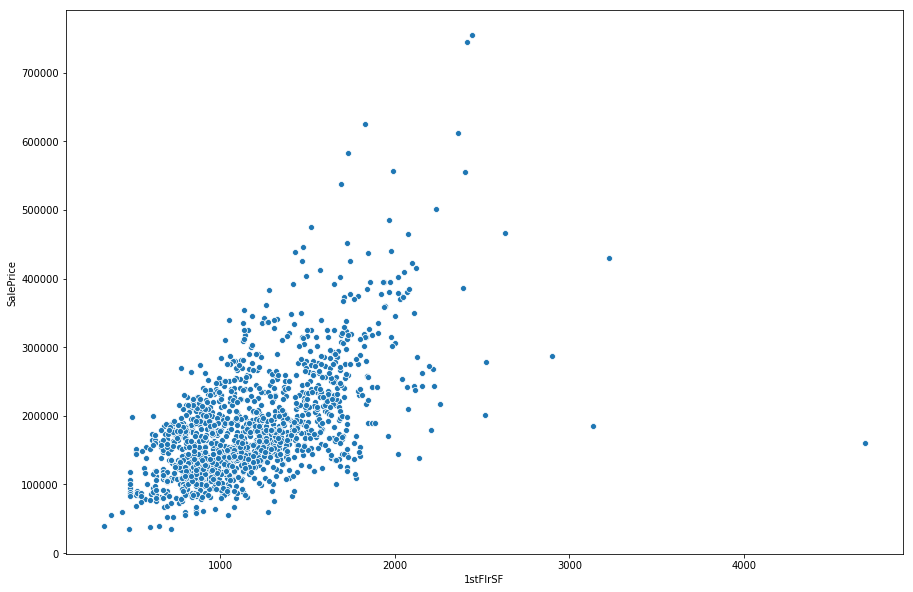

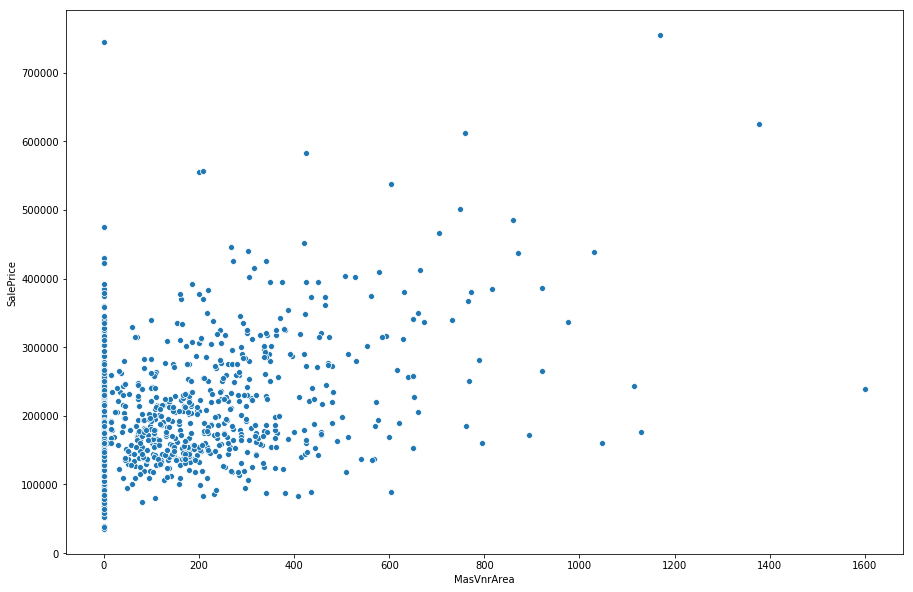

In [178]:
def customized_scatterplot(y, x):
    plt.subplots(figsize=(15, 10))
    sns.scatterplot(y=y, x=x)
    
customized_scatterplot(train['SalePrice'], train['OverallQual'])
customized_scatterplot(train['SalePrice'], train['GrLivArea'])
customized_scatterplot(train['SalePrice'], train['GarageArea'])
customized_scatterplot(train['SalePrice'], train['TotalBsmtSF'])
customized_scatterplot(train['SalePrice'], train['1stFlrSF'])
customized_scatterplot(train['SalePrice'], train['MasVnrArea'])

In [179]:
train = train[train.GrLivArea<4500]
train.reset_index(drop=True, inplace=True)
previous_train = train.copy()

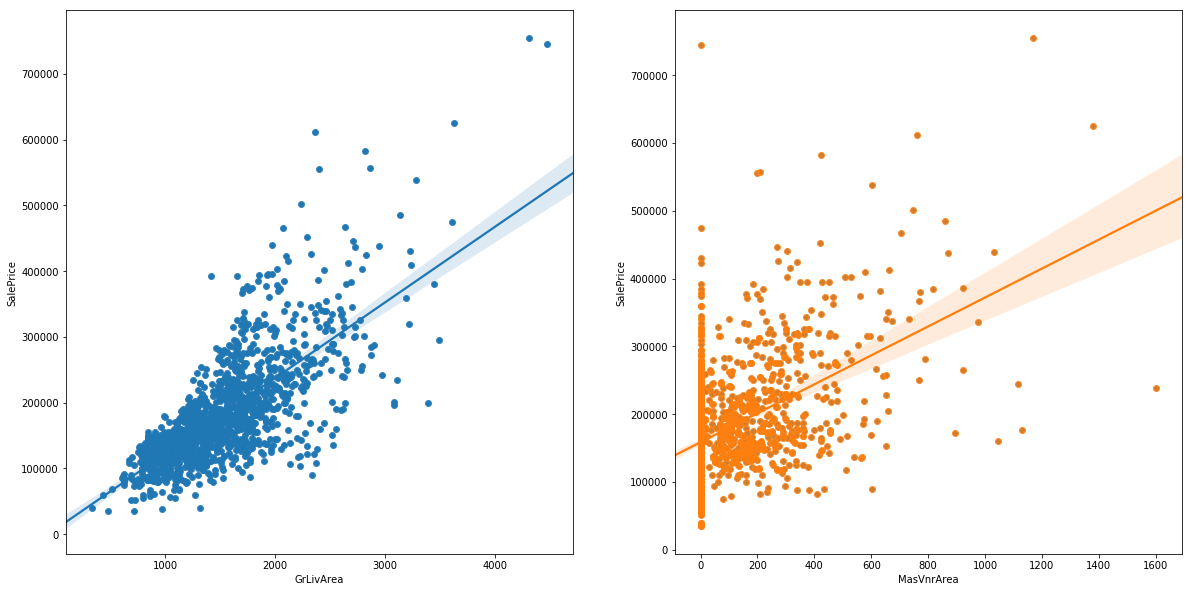

In [180]:
fig, (ax1, ax2) = plt.subplots(figsize=(20, 10), ncols=2, sharey=False)
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'], ax=ax1)
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], ax=ax1)

sns.scatterplot(x=train['MasVnrArea'], y=train['SalePrice'], ax=ax2)
sns.regplot(x=train['MasVnrArea'], y=train['SalePrice'], ax=ax2)

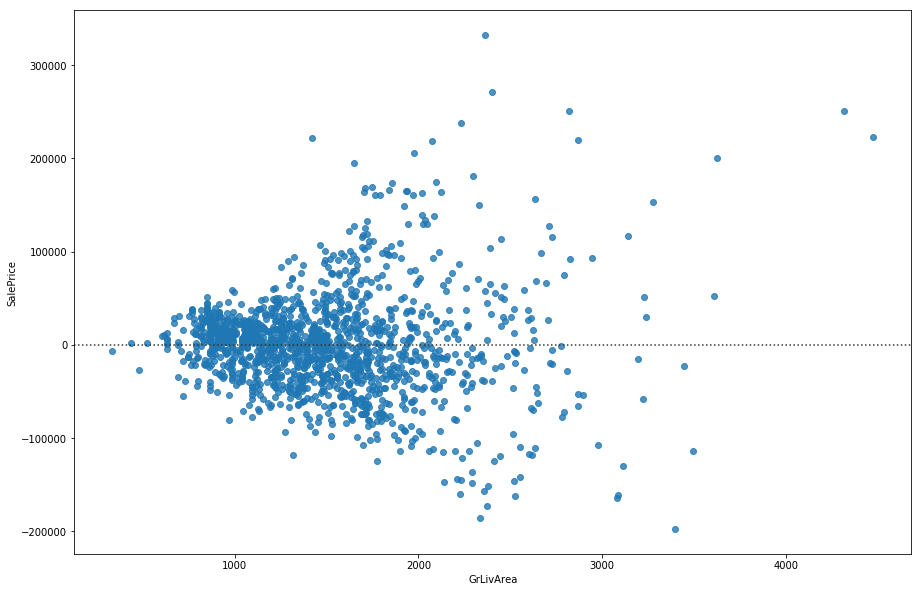

In [181]:
plt.subplots(figsize=(15, 10))
sns.residplot(train['GrLivArea'], train['SalePrice'])

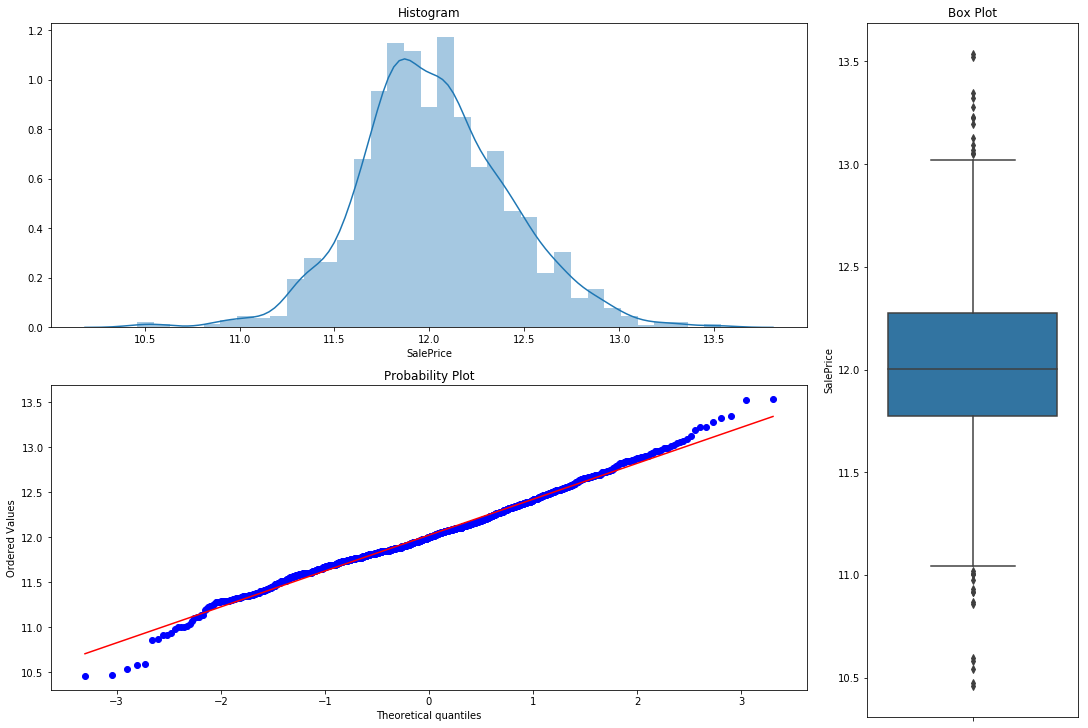

In [182]:
train['SalePrice'] = np.log1p(train['SalePrice'])
plotting_3_chart(train, 'SalePrice')

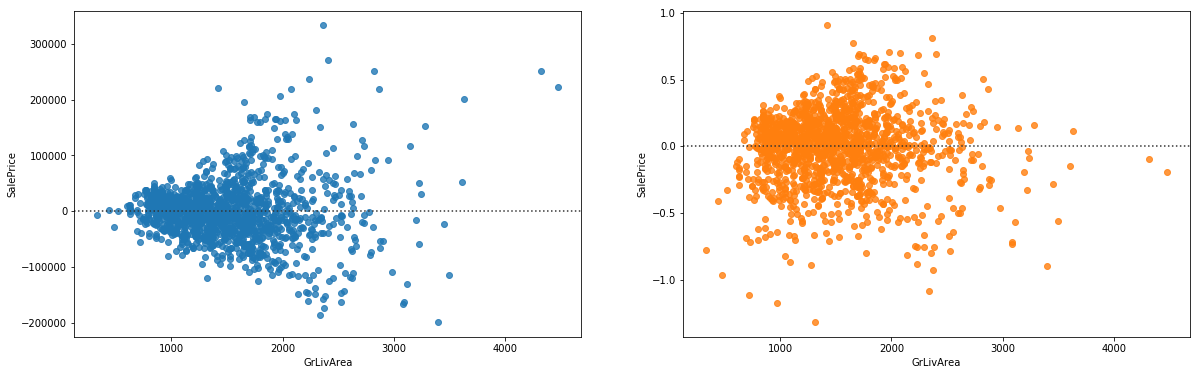

In [183]:
fig, (ax1, ax2) = plt.subplots(figsize=(20,6), ncols=2, sharey=False, sharex=False)
sns.residplot(x=previous_train['GrLivArea'], y=previous_train['SalePrice'], ax=ax1)
sns.residplot(x=train['GrLivArea'], y=train['SalePrice'], ax=ax2)

Text(0.5,1,'Heatmap of all the features')

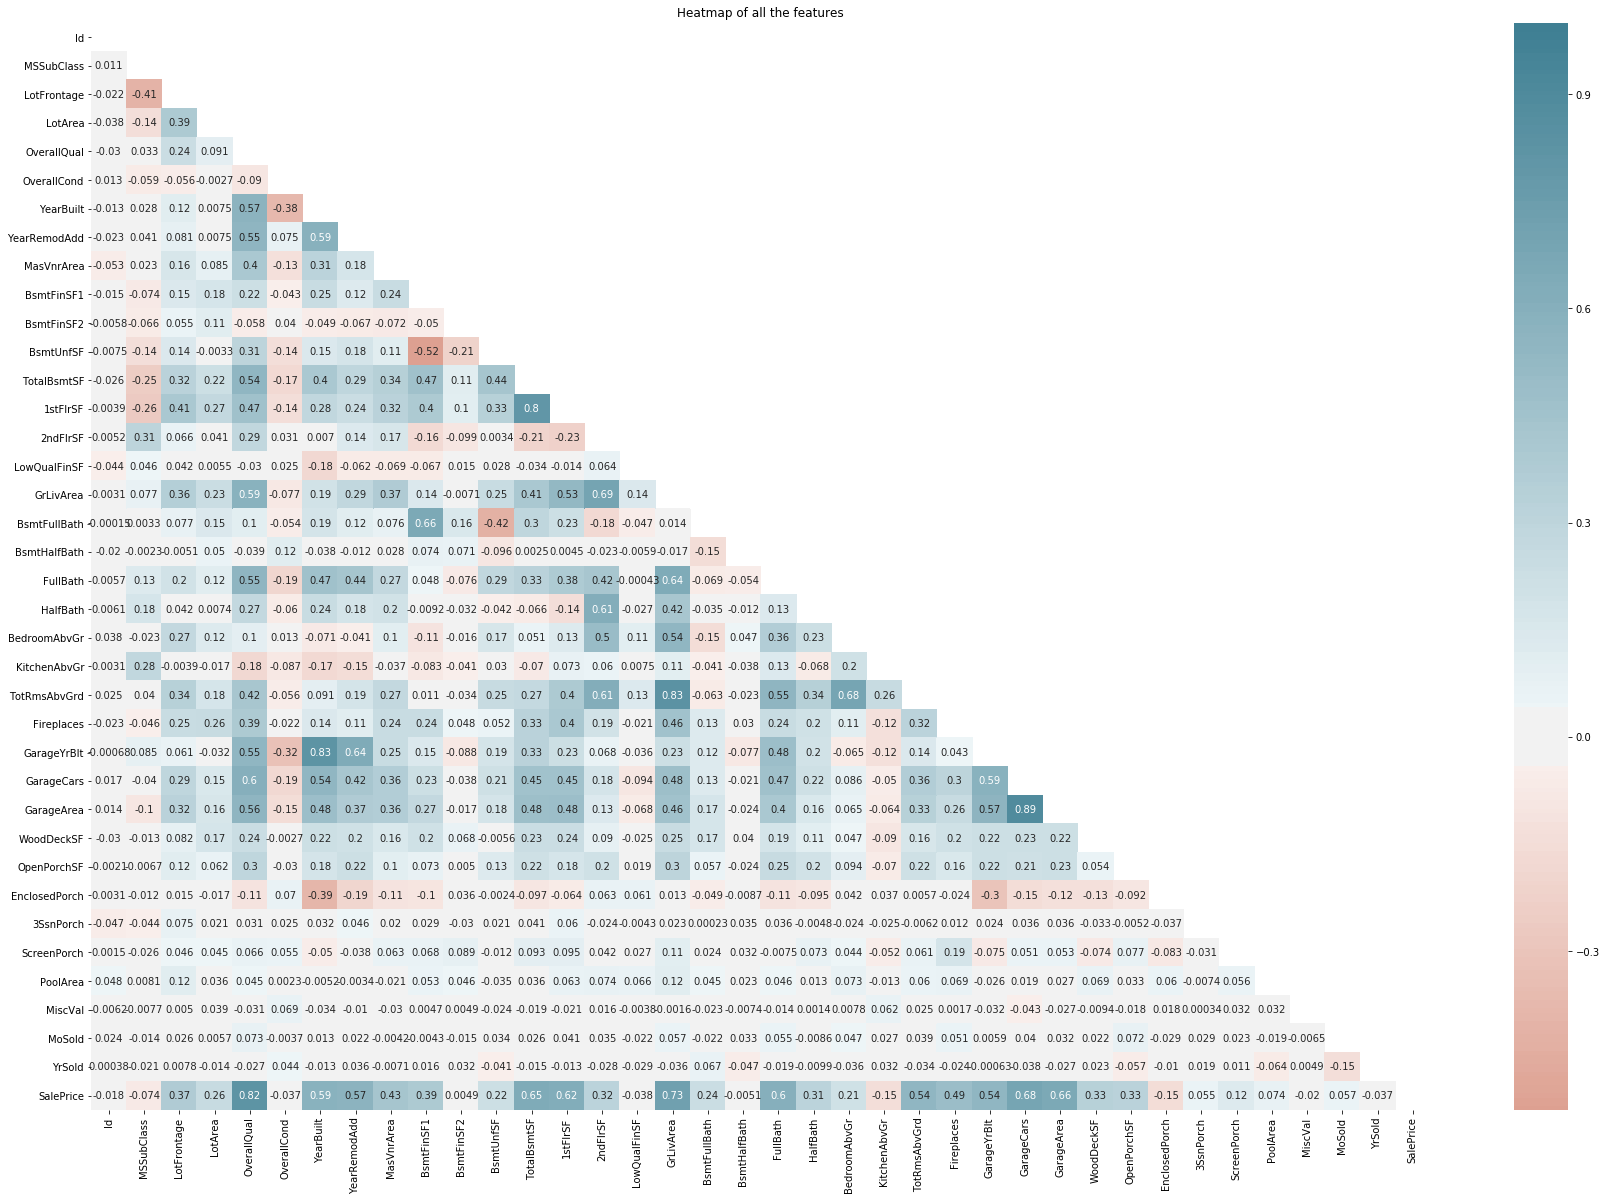

In [184]:
plt.subplots(figsize=(30, 20))
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train.corr(), cmap=sns.diverging_palette(20, 220, n=200),
           mask=mask, annot=True, center=0)
plt.title('Heatmap of all the features')

In [185]:
train.drop(columns=['Id'], axis=1, inplace=True)
test.drop(columns=['Id'], axis=1, inplace=True)
y = train['SalePrice'].reset_index(drop=True)
pre_train = train.copy()

In [186]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [187]:
feat = 'Fence'
print(all_data[feat].value_counts())
print(all_data[feat].unique())

MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


In [188]:
missing_feats = missing_percentage(all_data)
missing_feats[missing_feats['Types']!='object']

,Total,Percent,Types
LotFrontage,486,0.167,float64
GarageYrBlt,159,0.055,float64
MasVnrArea,23,0.008,float64
BsmtHalfBath,2,0.001,float64
BsmtFullBath,2,0.001,float64
GarageCars,1,0.000,float64
GarageArea,1,0.000,float64
TotalBsmtSF,1,0.000,float64
BsmtUnfSF,1,0.000,float64
BsmtFinSF2,1,0.000,float64


## Dealing with missing values

In [189]:
missing = missing_percentage(all_data)
# missing[missing['Types']!='object']
missing_val_col = ["Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']
# all_data[missing_val_col]
for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')

In [190]:
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']
for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)

In [191]:
# all_data['OverallCond'] = all_data['OverallCond'].astype(str)
# all_data['OverallQual'] = all_data['OverallQual'].astype(str)

In [192]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].\
                            transform(lambda x: x.fillna(x.mean()))

all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].\
                        transform(lambda x: x.fillna(x.mode()[0]))
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
# all_data['YearBuilt'] = all_data['YearBuilt'].astype(str)
# all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)
# all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)

all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr")

In [193]:
missing_percentage(all_data)

,Total,Percent,Types


In [194]:
def fixing_skewness(df):
    numeric_feats = df.dtypes[df.dtypes!='object'].index
    skewed_feats = df[numeric_feats].apply(lambda x:skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats)>0.5]
    skewed_features = high_skew.index
    
    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat]+1))

fixing_skewness(all_data)

## Feature engineering

In [195]:
# all_data.drop(['Utilities', 'Street', 'PoolQC'], axis=1, inplace=True)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + \
                        all_data['1stFlrSF'] + \
                        all_data['2ndFlrSF']
all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']
all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2']+\
                                all_data['1stFlrSF'] + all_data['2ndFlrSF'])
all_data['Total_Bathrooms'] = (all_data['FullBath'] + 0.5*all_data['HalfBath']+\
                              all_data['BsmtFullBath'] + 0.5*all_data['BsmtHalfBath'])
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch']+\
                             all_data['EnclosedPorch'] + all_data['ScreenPorch']+\
                             all_data['WoodDeckSF'])

In [196]:
all_data['happool'] = all_data['PoolArea'].apply(lambda x: 1 if x>0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x>0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x>0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x>0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x:1 if x>0 else 0)

## Creating Dummy Variables

In [197]:
final_features = pd.get_dummies(all_data).reset_index(drop=True)
final_features.shape

(2917, 358)

In [198]:
X = final_features.iloc[:len(y),:]
X_sub = final_features.iloc[len(y):, :]

In [199]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [200]:
def overfit_reducer(df):
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.4:
            overfit.append(i)
    overfit = list(overfit)
    return overfit

overfitted_features = overfit_reducer(X)
X = X.drop(overfitted_features, axis=1)
X_sub = X_sub.drop(overfitted_features, axis=1)

## Fitting model

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [202]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

lin_reg = LinearRegression()
cv = KFold(shuffle=True, random_state=42, n_splits=10)
scores = cross_val_score(lin_reg, X, y, cv=cv,
                        scoring='neg_mean_absolute_error')
scores.mean()

-0.231733710778035

In [203]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                   scoring='neg_mean_squared_error',
                                   cv=kfolds))
    return rmse


alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt,
                                            cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7,
                                              alphas=alphas2,
                                              random_state=42,
                                              cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7,
                                                       alphas=e_alphas,
                                                       cv=kfolds,
                                                       l1_ratio=e_l1ratio))

svr = make_pipeline(RobustScaler(), SVR(C=20,
                                       epsilon=0.008,
                                       gamma=0.0003))

gbr = GradientBoostingRegressor(n_estimators=3000,
                               learning_rate=0.05,
                               max_depth=4,
                               max_features='sqrt',
                               min_samples_leaf=15,
                               min_samples_split=10,
                               loss='huber',
                               random_state=42)

In [204]:
print("Elasticnet")
elastic_model = elasticnet.fit(X, y)
print("Lasso")
lasso_model = lasso.fit(X, y)
print("Ridge")
ridge_model = ridge.fit(X, y)
print("SVR")
svr_model = svr.fit(X, y)

Elasticnet
Lasso
Ridge
SVR


In [205]:
def blend_model(X):
    res = (0.25 * elastic_model.predict(X)) + \
            (0.25 * lasso_model.predict(X)) + \
            (0.25 * ridge_model.predict(X)) + \
            (0.25 * svr_model.predict(X))
    return res

In [206]:
print("blend: ", rmsle(y, blend_model(X)))
print("Ridge: ", rmsle(y, ridge_model.predict(X)))
print("Lasso: ", rmsle(y, lasso_model.predict(X)))
print("Elastic: ", rmsle(y, elastic_model.predict(X)))
print("SVR: ", rmsle(y, svr_model.predict(X)))

blend:  0.08613837882738731
Ridge:  0.09094447296540381
Lasso:  0.08668792135828979
Elastic:  0.08588775632566607
SVR:  0.08779734011854327


In [207]:
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:, 1] = np.floor(np.expm1(blend_model(X_sub)))
submission.to_csv('submission_2019_12-15.csv', index=False)